## Messy vs. Clean Room Detection Project with Convolutional Neural Network VGG19 
---
Judy Chen

**Import Modules:**

In [1]:
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from sklearn.model_selection import train_test_split 
from tensorflow.keras.optimizers import SGD

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

import cv2

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

**Load Training Dataset:**

In [2]:
path='/Users/chenmouse/Desktop/images_all'

In [3]:
data = []
label = []
Files = ['clean', 'messy']
label_val = 0

for files in Files:
    cpath = os.path.join(path, files)
    imglist=os.listdir(cpath)
    del imglist[15]
    for img in imglist:
        image = cv2.imread(os.path.join(cpath, img), cv2.IMREAD_UNCHANGED)
        imageRS = cv2.resize(image, (32, 32), interpolation=cv2.INTER_AREA)
        data.append(imageRS)
        label.append(label_val)
    label_val = 1

**Convert images and labels to numpy arrays and normalize dimensions of input images - scale pixels by 255:**

In [4]:
data_std=[]
for i in data:
    to_append=np.array(i, dtype=float)/255
    data_std.append(to_append)

In [5]:
data_std=np.asarray(data_std)

In [6]:
label=np.asarray(label)

**Split into test and train datasets:**

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data_std, label, test_size=0.2, random_state=1)

**Use preset Keras model VGG19**

In [8]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg19 = VGG19(input_shape = (32, 32, 3), weights = 'imagenet', include_top = False)
for layer in vgg19.layers:
  layer.trainable = False

In [9]:
post = tf.keras.layers.Flatten()(vgg19.output)
post = tf.keras.layers.Dense(224, activation = 'relu')(post)
post = tf.keras.layers.Dense(1, activation = 'sigmoid')(post)
model2 = tf.keras.models.Model(vgg19.input, post)
model2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'acc')
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [10]:
class my_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('acc') > 0.9:
      print('Valiation Reached 90% accuracy, stopping training.\n')
      self.model.stop_training = True
callback = my_callback()

In [11]:
Output2 = model2.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), steps_per_epoch=6, validation_steps=6, epochs=300, verbose=1, callbacks = [callback])

Epoch 1/300
6/6 [==============================] - 1s 146ms/step - loss: 0.6582 - acc: 0.6213 - val_loss: 0.6645 - val_acc: 0.5814
Epoch 2/300
6/6 [==============================] - 1s 108ms/step - loss: 0.4872 - acc: 0.7988 - val_loss: 0.5301 - val_acc: 0.7907
Epoch 3/300
6/6 [==============================] - 1s 110ms/step - loss: 0.4053 - acc: 0.8343 - val_loss: 0.5240 - val_acc: 0.7209
Epoch 4/300
6/6 [==============================] - 1s 109ms/step - loss: 0.3715 - acc: 0.8343 - val_loss: 0.5115 - val_acc: 0.7674
Epoch 5/300
6/6 [==============================] - 1s 110ms/step - loss: 0.3290 - acc: 0.8639 - val_loss: 0.4989 - val_acc: 0.7674
Epoch 6/300
6/6 [==============================] - 1s 110ms/step - loss: 0.3067 - acc: 0.8876 - val_loss: 0.5114 - val_acc: 0.7442
Epoch 7/300
6/6 [==============================] - 1s 110ms/step - loss: 0.2857 - acc: 0.8935 - val_loss: 0.5073 - val_acc: 0.7442
Epoch 8/300
6/6 [==============================] - 1s 110ms/step - loss: 0.2753 - a

**Fitting Model on Out-of-Sample Test Dataset**

Load Test Dataset:

In [21]:
path_test='/Users/chenmouse/Desktop/images_test'
imglist_t=sorted(os.listdir(path_test))
data_test = []
img_orig=[]
for i in imglist_t:
    image = cv2.imread(os.path.join(path_test, i), cv2.IMREAD_UNCHANGED)
    imgt=np.array(tf.image.resize(image, (32, 32), method = tf.image.ResizeMethod.BILINEAR, 
                                  preserve_aspect_ratio = True)).reshape(1, 32, 32, 3) 
    data_test.append(imgt)

**Take a look at test dataset images:**

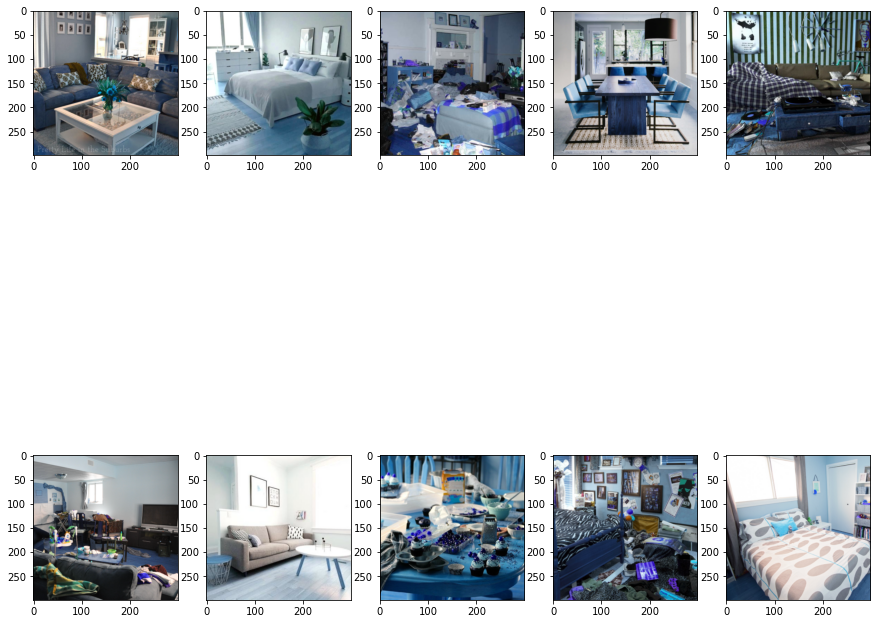

In [20]:
plt.figure(figsize=(15, 15))    
for r in range(10):
    ax = plt.subplot(2, 5, r+1)
    image = cv2.imread(os.path.join(path_test, imglist_t[r]), cv2.IMREAD_UNCHANGED)
    plt.imshow(image)

**Predict Test Dataset:**

In [13]:
predictions=[]
for t in range(0,10):
    predictions.append(model2.predict(data_test[t]).round(0).tolist())

In [14]:
pred_list_labels=[]
for i in predictions:
    #print(i)
    if i==[[0.0]]:
        pred_list_labels.append('Clean')
    else:
        pred_list_labels.append('Messy')

Create list of true values for test dataset labels:

In [15]:
labels_test = ['Clean', 'Clean', 'Messy', 'Clean', 'Messy', 'Messy', 'Clean', 'Messy', 'Messy', 'Clean']

**Aggregate Results**

In [16]:
pred_df=pd.DataFrame({'Picture No.': pd.Series(list(range(1,11))), 'Predicted Output': pd.Series(pred_list_labels),
                     'Actual Output':pd.Series(labels_test)})

In [17]:
def accuracy(df):
    if df['Predicted Output']==df['Actual Output']:
        val="Yes"
    else:
        val="No"
    return val

In [18]:
pred_df['Correct Prediction?']=pred_df.apply(accuracy, axis=1)

In [19]:
pred_df

,Picture No.,Predicted Output,Actual Output,Correct Prediction?
0,1,Clean,Clean,Yes
1,2,Clean,Clean,Yes
2,3,Clean,Messy,No
3,4,Clean,Clean,Yes
4,5,Clean,Messy,No
5,6,Clean,Messy,No
6,7,Clean,Clean,Yes
7,8,Messy,Messy,Yes
8,9,Clean,Messy,No
9,10,Clean,Clean,Yes


**The accuracy of test dataset is 60%. Of the wrong predictions, picture No. 9 and No.5 are messy rooms that can easily be mistaken as clean, as they both include objects with clearly defined edges.**